# SVM - Pedro

25/Abril/2023
Fuente: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [1]:
# Cargar paquetes
import warnings

# Filter out warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [2]:
# Cargar base de datos
df = pd.read_pickle("data_final.pkl")

In [3]:
# filter only to house bills and senate bills - Victor
df = df[(df['BillType'] == 'hr') | (df['bill_type'] == 's')]

In [4]:
# Pass either senate or congress
df['Target'] = np.where((df['PassH']==1) | (df['PassS']==1), 1, 0)

In [5]:
# Keep only my interest columns
Corpus = df[['summary', 'Target']]
column_name_mapping = {'summary': 'text', 'Target': 'label'}
Corpus.rename(columns=column_name_mapping, inplace=True)

In [6]:
# Start the pre-processing according to the article - takes around 30min
np.random.seed(500)
# Step - a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

In [7]:
# Splitting data
Corpus.dropna(subset=['label'], inplace=True)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)

In [8]:
# Encoding
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [9]:
# Vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'].values.astype(str))
Train_X_Tfidf = Tfidf_vect.transform(Train_X.values.astype(str))
Test_X_Tfidf = Tfidf_vect.transform(Test_X.values.astype(str))

In [10]:
print(Tfidf_vect.vocabulary_)

{'withdraws': 4954, 'congress': 926, 'approval': 291, 'north': 3050, 'american': 220, 'free': 1957, 'trade': 4619, 'agreement': 159, 'direct': 1325, 'president': 3480, 'provide': 3595, 'write': 4979, 'notice': 3056, 'withdrawal': 4952, 'government': 2047, 'canada': 597, 'mexico': 2835, 'authorizes': 390, 'secretary': 4092, 'army': 316, 'carry': 630, 'project': 3552, 'hurricane': 2214, 'storm': 4351, 'damage': 1134, 'reduction': 3762, 'west': 4914, 'beach': 446, 'new': 3008, 'river': 3992, 'carolina': 626, 'substantially': 4403, 'accordance': 34, 'plan': 3374, 'describe': 1266, 'report': 3877, 'chief': 704, 'engineer': 1596, 'date': 1140, 'september': 4130, 'periodic': 3324, 'monitoring': 2903, 'economic': 1502, 'life': 2649, 'city': 726, 'coastal': 772, 'december': 1161, 'modifies': 2896, 'improvement': 2283, 'change': 686, 'authorized': 388, 'maintenance': 2725, 'eight': 1527, 'foot': 1909, 'disability': 1333, 'benefit': 466, 'fairness': 1787, 'act': 61, 'amend': 216, 'title': 4591, '

In [11]:
# Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  90.86902873259298


In [12]:
# Vanilla SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  90.86902873259298


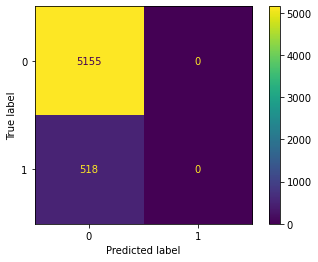

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [26]:
# Ajustando parametros C, el tipo de Kernel y gamma
SVM = svm.SVC(C=10.0, kernel='rbf', degree=3, gamma=10)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  89.42358540454785


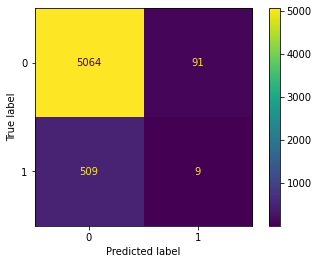

In [27]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [28]:
# Ajustando weights
SVM = svm.SVC(C=10.0, kernel='rbf', degree=3, gamma=10, class_weight={0: 1, 1: 4})
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  89.03578353604794


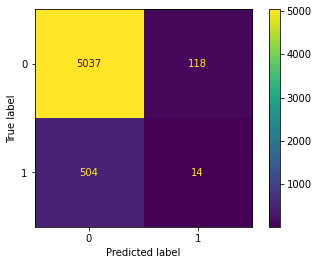

In [29]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [30]:
# Cambiando el kernel
SVM = svm.SVC(C=10.0, kernel='poly', degree=3, gamma=10, class_weight={0: 1, 1: 4})
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  87.90763264586639


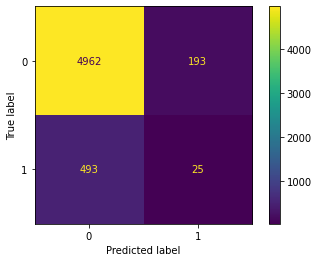

In [31]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [32]:
# Más peso
SVM = svm.SVC(C=10.0, kernel='poly', degree=3, gamma=10, class_weight={0: 1, 1: 20})
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  75.74475586109642


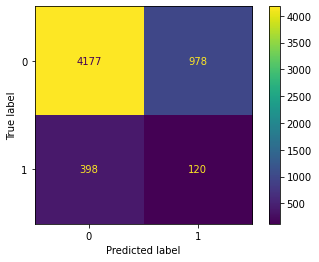

In [33]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [39]:
# Linear to adjust loss functions
SVM = svm.LinearSVC(C=10.0, class_weight={0: 1, 1: 10}, loss='hinge')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  67.60091662259828


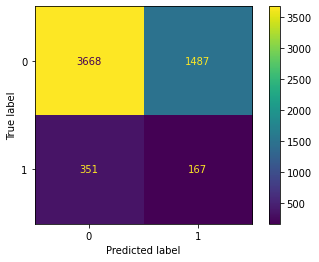

In [40]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [41]:
# Linear to adjust loss functions
SVM = svm.LinearSVC(C=10.0, class_weight={0: 1, 1: 5}, loss='hinge')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  80.733298078618


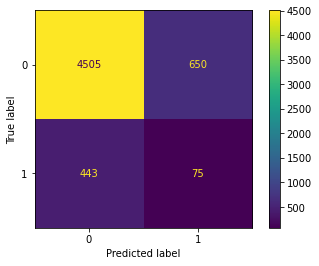

In [42]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()

In [43]:
# Linear to adjust loss functions
SVM = svm.LinearSVC(C=15.0, class_weight={0: 1, 1: 15}, loss='hinge')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  68.62330336682531


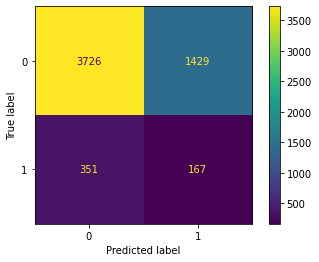

In [44]:
cm = confusion_matrix(Test_Y, predictions_SVM)
ConfusionMatrixDisplay(cm).plot()